In [69]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,RSI,MACD_Strategy,RSI_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
13,221.023331,221.935059,219.576706,219.743332,2187321,219.779147,219.268496,0.510651,0.236890,0.273760,57.416242,NaN,NaN,NaN,0,NaN,NaN
14,225.169998,228.536667,218.150009,220.000000,9571118,220.682206,219.896740,0.785466,0.350606,0.434860,62.477313,-1.0,0.0,-1.0,0,0.018761,0.000000
15,225.300003,226.130005,222.413330,225.260010,4153034,221.445334,220.452479,0.992855,0.482776,0.510078,57.590968,-1.0,0.0,-1.0,0,0.019349,0.000000
16,228.310104,228.320007,224.500000,225.323318,3211932,222.566991,221.236033,1.330958,0.656321,0.674638,60.776134,-1.0,0.0,-1.0,0,0.032968,0.000000
17,228.330002,228.739975,225.889999,228.275009,2908003,223.499723,221.923973,1.575750,0.843580,0.732170,67.050059,-1.0,0.0,-1.0,0,0.033058,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5081,296.630005,299.979889,296.329987,298.632904,12846873,289.291408,284.541801,4.749607,2.437617,2.311990,74.773305,-1.0,-1.0,-2.0,-1,0.342076,-0.425842
5082,297.899994,298.600006,296.339996,296.729889,8692841,290.615806,285.495958,5.119848,2.974063,2.145785,74.056792,-1.0,-1.0,-2.0,-1,0.347821,-0.428300
5083,298.454987,301.079987,297.519989,297.959991,11375914,291.821834,286.421603,5.400231,3.459297,1.940934,77.499790,-1.0,-1.0,-2.0,-1,0.350332,-0.429366
5084,297.809998,298.969910,296.510010,298.452209,9619696,292.743090,287.235060,5.508030,3.869044,1.638987,76.951060,-1.0,-1.0,-2.0,-1,0.347414,-0.428132


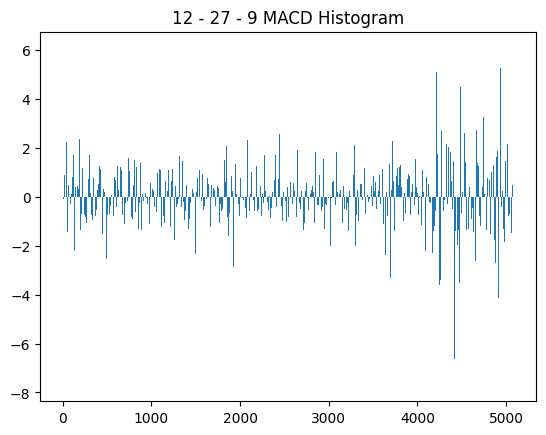

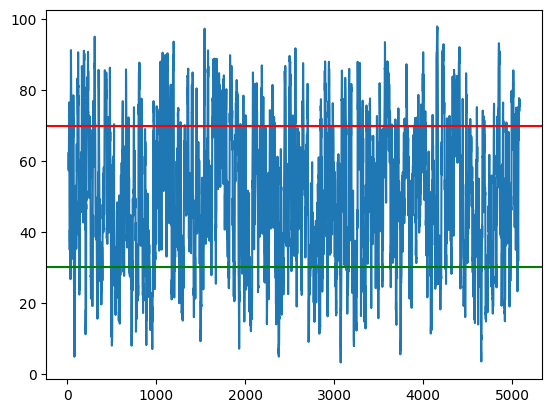

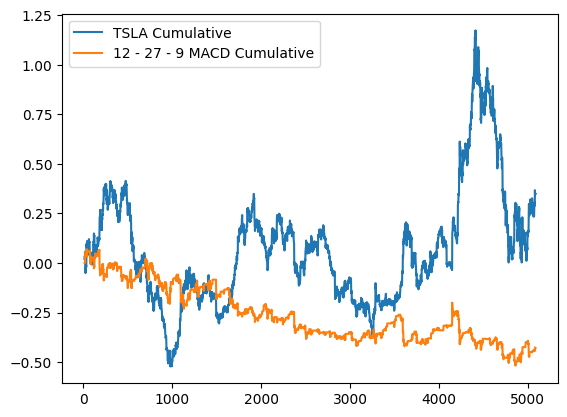

In [ ]:
TICKER = 'TSLA'
INTERVAL='1h'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MACD_strategy(df):

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)
    return df

def add_RSI(df, length=RSI_LENGTH):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color='red')
    plt.axhline(OVERSOLD, color='green')

    return df.dropna()

def add_RSI_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1, 
                     np.where(df['RSI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['MACD_Strategy'] + df['RSI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_RSI(df)
    df = add_MACD_strategy(df)
    df = add_RSI_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df